In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download delayedkarma/impressionist-classifier-data
! unzip impressionist-classifier-data.zip

 99% 2.17G/2.19G [00:20<00:00, 204MB/s]
100% 2.19G/2.19G [00:20<00:00, 114MB/s]
Archive:  impressionist-classifier-data.zip
  inflating: training/training/Cezanne/215457.jpg  
  inflating: training/training/Cezanne/215458.jpg  
  inflating: training/training/Cezanne/215459.jpg  
  inflating: training/training/Cezanne/215460.jpg  
  inflating: training/training/Cezanne/215462.jpg  
  inflating: training/training/Cezanne/215463.jpg  
  inflating: training/training/Cezanne/215466.jpg  
  inflating: training/training/Cezanne/215467.jpg  
  inflating: training/training/Cezanne/215468.jpg  
  inflating: training/training/Cezanne/215469.jpg  
  inflating: training/training/Cezanne/215470.jpg  
  inflating: training/training/Cezanne/215471.jpg  
  inflating: training/training/Cezanne/215473.jpg  
  inflating: training/training/Cezanne/215474.jpg  
  inflating: training/training/Cezanne/215475.jpg  
  inflating: training/training/Cezanne/215476.jpg  
  inflating: training/training/Cezanne/21547

In [4]:
import numpy as np
import pandas as pd
import os
import torchvision
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torch import Generator
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import itertools
import time
import copy
from torchvision.models import ResNet50_Weights
from torch.nn import Module
from torchvision import models
import torch.optim as optim
import seaborn as sns
import torchvision
import torch.nn as nn
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

In [5]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 6050
setup_seed(SEED)

In [6]:
artists = ['Cezanne', 'Degas', 'Gauguin', 'Hassam', 'Matisse', 'Monet', 'Pissarro', 'Renoir', 'Sargent', 'VanGogh']
artists = os.listdir('training/training')

In [7]:
transformation = Compose([
    Resize((256,256)),
    ToTensor()
])
transformation_train = Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    ToTensor()
])

image_datasets = {}
# for phase in ['training', 'validation']:
#   image_datasets[phase] = ImageFolder(f'/content/{phase}/{phase}', transform=transformation)
image_datasets['training'] = ImageFolder(f'/content/training/training', transform=transformation_train)
image_datasets['validation'] = ImageFolder(f'/content/validation/validation', transform=transformation)

# size_all_train = len(image_datasets['training'])
# size_test_from_train = int(size_all_train * 0.125)
# size_train = size_all_train - size_test_from_train

# image_datasets['training'], image_datasets_test_from_train = random_split(image_datasets['training'], [size_train, size_test_from_train], generator=Generator().manual_seed(SEED))

# size_all_validation = len(image_datasets['validation'])
# size_test_from_validation = int(size_all_validation * 0.25)
# size_validation = size_all_validation - size_test_from_validation

# image_datasets['validation'], image_datasets_test_from_validation = random_split(image_datasets['validation'], [size_validation, size_test_from_validation], generator=Generator().manual_seed(SEED))

# image_datasets['testing'] = ConcatDataset([image_datasets_test_from_train, image_datasets_test_from_validation])

size_all_validation = len(image_datasets['validation'])
size_test_from_validation = int(size_all_validation * 0.5)
size_validation = size_all_validation - size_test_from_validation

image_datasets['validation'], image_datasets['testing'] = random_split(image_datasets['validation'], [size_validation, size_test_from_validation], generator=Generator().manual_seed(SEED))

# EDIT BATCH SIZE HERE (tune learning rate using 16, then, once the learning rate is fixed, try 32, 48, 64)
BS = 32
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation', 'testing']}
print(dataset_sizes)

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{'training': 3988, 'validation': 495, 'testing': 495}
cuda:0


In [8]:
for artist in artists:
    exec(f"train_{artist}_dir = os.path.join('training/training', '{artist}')")
    exec(f"train_{artist}_filenames = os.listdir(train_{artist}_dir)")
    exec(f"valid_{artist}_dir = os.path.join('validation/validation', '{artist}')")
    exec(f"valid_{artist}_filenames = os.listdir(valid_{artist}_dir)")

In [9]:
# define the model training function
def train_model(model, criterion, optimizer, num_epochs=25):
    # initialize the start time
    since = time.time()

    # initialize the best weight configuration and accuracy of the model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # initialize the lists that will store the accuracies and losses across the epochs
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []

    # iterate over the epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluate mode

            # initialize the running losses and corrects
            running_loss = 0.0
            running_corrects = 0

            # iterate over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                # track history if only in train
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward pass
                    # optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # calculate and update epoch statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # print epoch performance statistics
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # store epoch performance statistics
            if phase == 'training':
              train_accs.append(epoch_acc.item())
              train_losses.append(epoch_loss)
            else:
              val_accs.append(epoch_acc.item())
              val_losses.append(epoch_loss)

            # deep copy the model to reflect the best weight configuration
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # print the training statistics
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accs, train_losses, val_accs, val_losses

In [10]:
!pip install googlenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
global_LR = 5e-4
global_BS = 32
global_WD = 1e-5
# global_DR = 0.0

In [12]:
BS = 32
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BS, shuffle=True) for x in ['training', 'validation', 'testing']}

In [13]:
from googlenet_pytorch import GoogLeNet
model_google = GoogLeNet.from_pretrained("googlenet")
model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 91.3MB/s]


Loaded pretrained weights for googlenet


## Model 1: DR = 0.0 -------- OPTIMAL MODEL
- batch_size= 32
- LR = 5e-4
- WD = 1e-5
- Data Augmentation

$\therefore$ 83.6% Validation Accuracy

## Model 2: DR = 0.1
- batch_size= 32
- LR = 5e-4
- WD = 1e-5
- Data Augmentation

In [28]:
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
    param.requires_grad = False

# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
    for i in [5]:
        if name.startswith(f'inception{5}') or name.startswith('aux'):
            param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.1
# construct the fully connected head which will receive the flattened convolutional output

'''
The final layer of GoogLeNet is a global average pooling layer that reduces the spatial 
dimensions of the feature maps to 1x1 and produces a tensor of size (1, 1024).
''' 
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
    print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [29]:
criterion_2 = nn.CrossEntropyLoss()

# set the optimizer for the parameters of the whole model
optimizer_2 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=global_LR, weight_decay=global_WD)

In [30]:
model_2, train_accs_2, train_losses_2, val_accs_2, val_losses_2 = train_model(model_google, criterion_2, optimizer_2, num_epochs=7)

Epoch 1/7
----------
training Loss: 1.3636 Acc: 0.5735
validation Loss: 0.9275 Acc: 0.7253

Epoch 2/7
----------
training Loss: 0.8743 Acc: 0.7274
validation Loss: 0.7455 Acc: 0.7636

Epoch 3/7
----------
training Loss: 0.6668 Acc: 0.7934
validation Loss: 0.7146 Acc: 0.7636

Epoch 4/7
----------
training Loss: 0.5848 Acc: 0.8144
validation Loss: 0.7602 Acc: 0.7596

Epoch 5/7
----------
training Loss: 0.4691 Acc: 0.8516
validation Loss: 0.6996 Acc: 0.7859

Epoch 6/7
----------
training Loss: 0.4042 Acc: 0.8726
validation Loss: 0.6724 Acc: 0.8040

Epoch 7/7
----------
training Loss: 0.3312 Acc: 0.8982
validation Loss: 0.7487 Acc: 0.7596

Training complete in 23m 59s
Best val Acc: 0.804040


Text(0.5, 1.0, 'Loss')

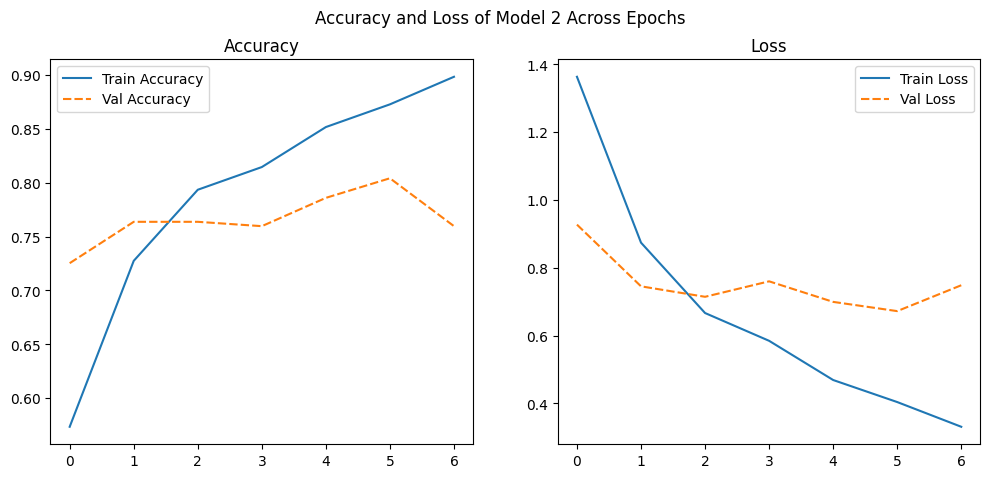

In [31]:
data_acc_2 = pd.DataFrame({"Train Accuracy": train_accs_2, "Val Accuracy": val_accs_2})
data_loss_2 = pd.DataFrame({"Train Loss": train_losses_2, "Val Loss": val_losses_2})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 2 Across Epochs")

sns.lineplot(data=data_acc_2, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_2, ax = axs[1])
axs[1].set_title("Loss")

In [32]:
result_2 = pd.concat([data_acc_2, data_loss_2], axis = 1)
result_2

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.573470,0.725253,1.363600,0.927502
1,0.727432,0.763636,0.874335,0.745477
2,0.793380,0.763636,0.666751,0.714623
3,0.814443,0.759596,0.584772,0.760241
4,0.851555,0.785859,0.469137,0.699591
5,0.872618,0.804040,0.404151,0.672370
6,0.898195,0.759596,0.331207,0.748652


## Model 3: DR = 0.2
- batch_size= 32
- LR = 5e-4
- WD = 1e-5
- Data Augmentation

In [20]:
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
    param.requires_grad = False

# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
    for i in [5]:
        if name.startswith(f'inception{5}') or name.startswith('aux'):
            param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.2
# construct the fully connected head which will receive the flattened convolutional output

'''
The final layer of GoogLeNet is a global average pooling layer that reduces the spatial 
dimensions of the feature maps to 1x1 and produces a tensor of size (1, 1024).
''' 
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
    print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [21]:
criterion_3 = nn.CrossEntropyLoss()

# set the optimizer for the parameters of the whole model
optimizer_3 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=global_LR, weight_decay=global_WD)

In [22]:
model_3, train_accs_3, train_losses_3, val_accs_3, val_losses_3 = train_model(model_google, criterion_3, optimizer_3, num_epochs=7)

Epoch 1/7
----------
training Loss: 1.4056 Acc: 0.5494
validation Loss: 0.9456 Acc: 0.6949

Epoch 2/7
----------
training Loss: 0.8797 Acc: 0.7317
validation Loss: 0.8163 Acc: 0.7434

Epoch 3/7
----------
training Loss: 0.7004 Acc: 0.7876
validation Loss: 0.7005 Acc: 0.7657

Epoch 4/7
----------
training Loss: 0.5879 Acc: 0.8147
validation Loss: 0.6764 Acc: 0.7960

Epoch 5/7
----------
training Loss: 0.4852 Acc: 0.8498
validation Loss: 0.6307 Acc: 0.7980

Epoch 6/7
----------
training Loss: 0.4155 Acc: 0.8681
validation Loss: 0.6975 Acc: 0.7677

Epoch 7/7
----------
training Loss: 0.3712 Acc: 0.8826
validation Loss: 0.7189 Acc: 0.7980

Training complete in 23m 58s
Best val Acc: 0.797980


Text(0.5, 1.0, 'Loss')

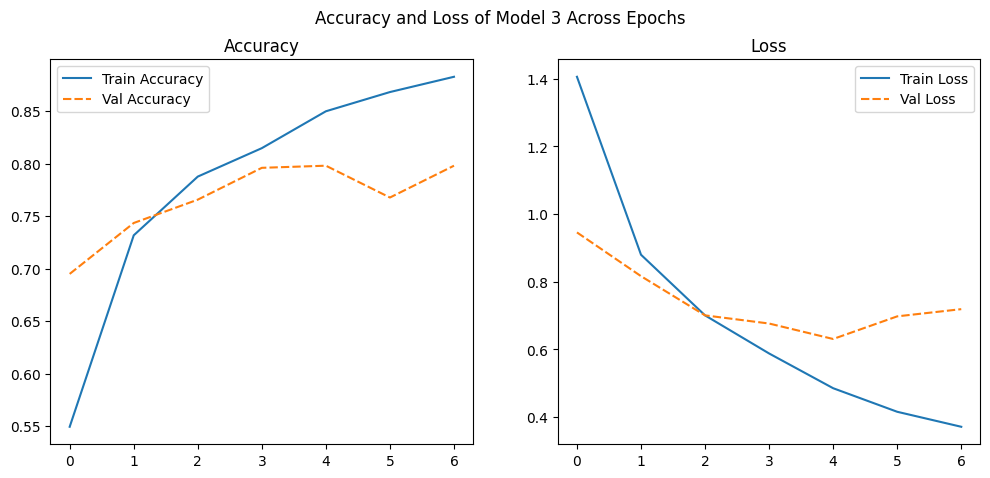

In [23]:
data_acc_3 = pd.DataFrame({"Train Accuracy": train_accs_3, "Val Accuracy": val_accs_3})
data_loss_3 = pd.DataFrame({"Train Loss": train_losses_3, "Val Loss": val_losses_3})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 3 Across Epochs")

sns.lineplot(data=data_acc_3, ax = axs[0])
axs[0].set_title("Accuracy")


sns.lineplot(data=data_loss_3, ax = axs[1])
axs[1].set_title("Loss")

In [24]:
result_3 = pd.concat([data_acc_3, data_loss_3], axis = 1)
result_3

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.549398,0.694949,1.405630,0.945621
1,0.731695,0.743434,0.879674,0.816345
2,0.787613,0.765657,0.700425,0.700468
3,0.814694,0.795960,0.587854,0.676369
4,0.849799,0.797980,0.485192,0.630673
5,0.868104,0.767677,0.415544,0.697548
6,0.882648,0.797980,0.371213,0.718865


## Model 3: DR = 0.4
- batch_size= 32
- LR = 5e-4
- WD = 1e-5
- Data Augmentation

In [25]:
model_google = GoogLeNet.from_pretrained("googlenet")

# freeze all of the parameters in the model
for param in model_google.parameters():
    param.requires_grad = False

# unfreeze the parameters in the last residual block of the architecture
for name, param in model_google.named_parameters():
    for i in [5]:
        if name.startswith(f'inception{5}') or name.startswith('aux'):
            param.requires_grad = True

# EDIT DROPOUT RATE HERE (dropout actually doesn't help here, so let's use L2 regularization instead)
DO = 0.4
# construct the fully connected head which will receive the flattened convolutional output

'''
The final layer of GoogLeNet is a global average pooling layer that reduces the spatial 
dimensions of the feature maps to 1x1 and produces a tensor of size (1, 1024).
''' 
model_google.fc = nn.Sequential(
               nn.Linear(1024, 512), # 2048 -> 1024
               nn.BatchNorm1d(512),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),
               
               nn.Linear(512, 128),
               nn.BatchNorm1d(128),
               nn.ReLU(inplace=True),
               nn.Dropout(DO),

              #  nn.Linear(128, 32),
              #  nn.BatchNorm1d(32),
              #  nn.ReLU(inplace=True),
              #  #nn.Dropout(DO),

               nn.Linear(128, len(artists)))

# print all the named parameters in the model to confirm that the correct ones are frozen and unfrozen
for name, param in model_google.named_parameters():
    print(name, param.requires_grad)

model_google = model_google.to(device)
model_google.aux_logits = False ### NEVER REMOVE THIS LINE

Loaded pretrained weights for googlenet
conv1.conv.weight False
conv1.bn.weight False
conv1.bn.bias False
conv2.conv.weight False
conv2.bn.weight False
conv2.bn.bias False
conv3.conv.weight False
conv3.bn.weight False
conv3.bn.bias False
inception3a.branch1.conv.weight False
inception3a.branch1.bn.weight False
inception3a.branch1.bn.bias False
inception3a.branch2.0.conv.weight False
inception3a.branch2.0.bn.weight False
inception3a.branch2.0.bn.bias False
inception3a.branch2.1.conv.weight False
inception3a.branch2.1.bn.weight False
inception3a.branch2.1.bn.bias False
inception3a.branch3.0.conv.weight False
inception3a.branch3.0.bn.weight False
inception3a.branch3.0.bn.bias False
inception3a.branch3.1.conv.weight False
inception3a.branch3.1.bn.weight False
inception3a.branch3.1.bn.bias False
inception3a.branch4.1.conv.weight False
inception3a.branch4.1.bn.weight False
inception3a.branch4.1.bn.bias False
inception3b.branch1.conv.weight False
inception3b.branch1.bn.weight False
inception3

In [26]:
criterion_4 = nn.CrossEntropyLoss()

# set the optimizer for the parameters of the whole model
optimizer_4 = optim.Adam(filter(lambda p: p.requires_grad, model_google.parameters()), lr=global_LR, weight_decay=global_WD)

In [27]:
model_4, train_accs_4, train_losses_4, val_accs_4, val_losses_4 = train_model(model_google, criterion_4, optimizer_4, num_epochs=7)

Epoch 1/7
----------
training Loss: 1.5597 Acc: 0.4860
validation Loss: 1.0468 Acc: 0.6949

Epoch 2/7
----------
training Loss: 1.0225 Acc: 0.6871
validation Loss: 0.7993 Acc: 0.7455

Epoch 3/7
----------
training Loss: 0.8082 Acc: 0.7553
validation Loss: 0.7264 Acc: 0.7758

Epoch 4/7
----------
training Loss: 0.6688 Acc: 0.8012
validation Loss: 0.6947 Acc: 0.7798

Epoch 5/7
----------
training Loss: 0.5892 Acc: 0.8124
validation Loss: 0.6548 Acc: 0.8040

Epoch 6/7
----------
training Loss: 0.5383 Acc: 0.8380
validation Loss: 0.6613 Acc: 0.7960

Epoch 7/7
----------
training Loss: 0.4296 Acc: 0.8724
validation Loss: 0.6572 Acc: 0.7838

Training complete in 24m 6s
Best val Acc: 0.804040


In [ ]:
data_acc_4 = pd.DataFrame({"Train Accuracy": train_accs_4, "Val Accuracy": val_accs_4})
data_loss_4 = pd.DataFrame({"Train Loss": train_losses_4, "Val Loss": val_losses_4})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.suptitle("Accuracy and Loss of Model 4 Across Epochs")

sns.lineplot(data=data_acc_4, ax = axs[0])
axs[0].set_title("Accuracy")

sns.lineplot(data=data_loss_4, ax = axs[1])
axs[1].set_title("Loss")

In [ ]:
result_4 = pd.concat([data_acc_4, data_loss_4], axis = 1)
result_4